In [1]:
import openmc
import math
import numpy as np
import matplotlib.pyplot as plt
%env OPENMC_CROSS_SECTIONS=/home/benve/lib/endfb80/endfb-viii.0-hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/home/benve/lib/endfb80/endfb-viii.0-hdf5/cross_sections.xml


# Materials configuration
In this section, materials has to given.
In order to modify the code, I recommend to touch only the 'tungsten' line, substituting 'W' with another material (such as 'Fe', 'C', 'Be'.) 
Also, remember to modify the density.


In [ ]:
# Materials
vacuum = openmc.Material(name = 'vacuum') # the basic idea is to define vacuum as an extreme low density H gas
vacuum.add_nuclide('H1',1)
vacuum.set_density('g/cm3',1e-9)

tungsten = openmc.Material(name = 'tungsten') # first 1cm of tungsten
tungsten.add_element('W',1)
tungsten.set_density('g/cm3',19.3)

inconel = openmc.Material(name = 'inconel') # Inconel718, alloy steel
inconel.add_element('Ni', 53.8, percent_type ='wo')
inconel.add_element('Fe', 17.8, percent_type ='wo')
inconel.add_element('Cr', 17.9, percent_type ='wo')
inconel.add_element('Co', 0.17, percent_type ='wo')
inconel.add_element('Mo', 2.92, percent_type ='wo')
inconel.add_element('Al', 0.47, percent_type ='wo')
inconel.add_element('Ti', 1.01, percent_type ='wo')
inconel.add_element('Nb', 5.40, percent_type ='wo')
inconel.add_element('C', 0.025, percent_type ='wo')
inconel.add_element('B', 0.004, percent_type ='wo')
inconel.add_element('Si', 0.07, percent_type ='wo')
inconel.add_element('Mn', 0.06, percent_type ='wo')
inconel.add_element('Cu', 0.04, percent_type ='wo')
inconel.set_density('g/cm3', 8.2)

flibe = openmc.Material(name = 'flibe') # FLiBe breeder, made of Li2BeF4
flibe.add_element('Li', 2) #enrichment=90, enrichment_target='Li6', enrichment_type='wo')
flibe.add_element('Be', 1)
flibe.add_element('F', 4)
flibe.set_density('g/cm3', 1.94)

materials = openmc.Materials([vacuum, tungsten, inconel, flibe])
materials.export_to_xml()

Material
	ID             =	2
	Name           =	tungsten
	Temperature    =	None
	Density        =	19.3 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	W180           =	0.0012       [ao]
	W182           =	0.265        [ao]
	W183           =	0.1431       [ao]
	W184           =	0.3064       [ao]
	W186           =	0.2843       [ao]



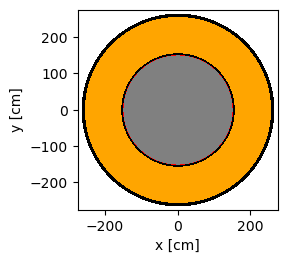

In [ ]:
# Creating the reactor universe and geometry
spheres = [openmc.Sphere(r = 150.0),
           openmc.Sphere(r = 151.0),
           openmc.Sphere(r = 156.0),
           openmc.Sphere(r = 256.0),
           openmc.Sphere(r = 265.0, boundary_type = 'vacuum')]

vacuum_cell = openmc.Cell(fill = None, region = -spheres[0])
tungsten_cell = openmc.Cell(fill = tungsten, region = +spheres[0] & -spheres[1] )
inconel_cell = openmc.Cell(fill = inconel, region = +spheres[1] & -spheres[2])
breeder_cell = openmc.Cell(fill = flibe, region = +spheres[2] & -spheres[3])
inconel_cell2 = openmc.Cell(fill = inconel, region = +spheres[3] & -spheres[4])


reactor_universe = openmc.Universe(cells = [vacuum_cell,tungsten_cell,inconel_cell,breeder_cell,inconel_cell2])
reactor_universe.plot(width=(550,550), colors = {vacuum_cell: 'grey', tungsten_cell: 'red', inconel_cell:'black', breeder_cell: 'orange', inconel_cell2:'black'})

geometry = openmc.Geometry(reactor_universe)
geometry.export_to_xml()

# Masses and density data
If you want to change material, in this section is important to change density and molar mass.

In [ ]:
n_particles = 1.773e20
r_out = 151
r_in = 150
tungsten_volume = 4/3 * math.pi * (r_out**3 - r_in**3)

m_W = tungsten_volume*19.3

N_A = 6.022e23
M_M = 183.84

n_W = m_W*N_A/M_M

Tungsten total mass =  5493406.925864993 g
Total Tungsten atoms = 1.7994612982788833e+28


In [5]:
# Simulation parameters
point = openmc.stats.Point((0,0,0)) # Deciding the center as the starting point
energy = openmc.stats.Discrete([14.1e6],1) # Discrete([energy],[probability]), in this case, im fine with a 100% neutron at a 14.1MeV
angle = openmc.stats.Isotropic() # Gives me the angle, in this case isotropic

src = openmc.IndependentSource(space = point, energy = energy, angle = angle)
settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.source = src
settings.batches = 10
settings.particles = 100000
settings.export_to_xml()

# Tallies section
The damage.nuclides line has to be change if you want to tally other isotopes. 
Each isotope of the material has to be written.

In [ ]:
# Defining tallies
tallies_file = openmc.Tallies()

openmc.mgxs.GROUP_STRUCTURES.keys()

energies_vitamin = openmc.mgxs.GROUP_STRUCTURES['VITAMIN-J-175']
energy_filter = openmc.EnergyFilter(energies_vitamin)

flux = openmc.Tally(name = 'flux')
flux.filters = [openmc.CellFilter(tungsten_cell)]
flux.filters.append(energy_filter)
flux.scores = ['flux']
tallies_file.append(flux)

damage = openmc.Tally(name = 'damage')
damage.filters = [openmc.CellFilter(tungsten_cell)]
damage.nuclides = ['W180','W182','W183','W184','W186']
damage.scores = ['444']
tallies_file.append(damage)

tallies_file.export_to_xml()

/home/benve/miniforge3/envs/openmc-env/lib/python3.13/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)


In [7]:
openmc.run(geometry_debug=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
sp = openmc.StatePoint('statepoint.10.h5')

# Calculation of DPA
This section contains the calculation part.
The data that has to be modify are:
- Threshold energy, depends on each material
- b and c factors

In [ ]:
energy_disp = sp.get_tally(name = 'damage')
df = energy_disp.get_pandas_dataframe()
print(df)

energy_disp_tot = energy_disp.mean.sum()
print('Total energy in eV/source: ', f"{energy_disp_tot:.3f}")

E_d = 70 #Tungsten displacement threshold
displacements_per_source = 0.8*energy_disp_tot/(2*E_d) # NRT

dpa_NRT = displacements_per_source*n_particles/n_W*60*60*24*365
print('DPA/FPY, using NRT: ', f"{dpa_NRT:.3f}")

b = -0.58
c = 0.11
surviving_factor = (1-c)*(displacements_per_source)**b + c
print('Surviving factor', f"{surviving_factor:.3f}")
dpa_arc_NRT = displacements_per_source*surviving_factor*n_particles/n_W*60*60*24*365
print('DPA/FYP, using arc-NRT', f"{dpa_arc_NRT:.3f}")

   cell nuclide          score     mean  std. dev.
0     2    W180  damage-energy 1.69e+01   2.33e-02
1     2    W182  damage-energy 3.87e+03   5.35e+00
2     2    W183  damage-energy 2.01e+03   2.65e+00
3     2    W184  damage-energy 4.37e+03   6.00e+00
4     2    W186  damage-energy 4.05e+03   5.55e+00
Total energy in eV/source:  14310.512
DPA/FPY, using NRT:  25.409
Surviving factor 0.179
DPA/FYP, using arc-NRT 4.553


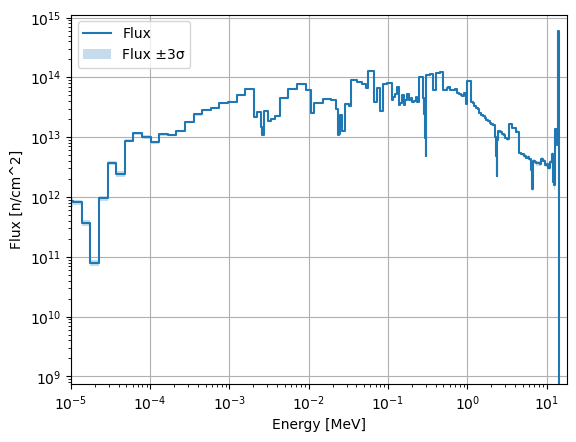

In [10]:
flux = sp.get_tally(scores = ['flux'])
flux_value = flux.mean.flatten()*n_particles/tungsten_volume
flux_std = flux.std_dev.flatten()*n_particles/tungsten_volume

fig, ax = plt.subplots()
ax.step(energies_vitamin[:-1]/1e6, flux_value, where='post', label='Flux')
ax.fill_between(
    energy_filter.values[:-1]/(1e6),
    flux_value - 3*flux_std,
    flux_value + 3*flux_std,
    step = 'post',
    alpha = 0.25,
    label = 'Flux ±3σ',   
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Flux [n/cm^2]')
ax.set_xlim(1e-5, 18)
ax.grid()
ax.legend()